In [2]:

!  pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1

In [3]:
! pip install fastai pandas scikit-learn IPython opendatasets numpy matplotlib seaborn --quiet


In [4]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [5]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [6]:
from fastai.collab import *

path = untar_data(URLs.ML_100k)

In [7]:
path

Path('/root/.fastai/data/ml-100k')

In [8]:
ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names=['user', 'movie', 'rating', 'timestamp']
)

In [9]:
ratings

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [10]:
# no extra data cleaning is required the dataset is look good
ratings.isna().sum()

user         0
movie        0
rating       0
timestamp    0
dtype: int64

In [11]:
ratings['rating'].unique()

array([3, 1, 2, 4, 5])

In [12]:
len(ratings['user'].unique())


943

In [13]:
len(ratings['movie'].unique())

1682

the movieLens dataset contains 25 million rows, we chose to work with subset of the data for learning purposes.

### creating the DataLoaders

In [14]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', 
                     usecols=(0,1), names=('movie','title'), header=None)

In [15]:
movies[movies['title'] == 'Kolya (1996)']

,movie,title
241,242,Kolya (1996)


Now we can merge the two dataframes the rating and the movie dataframes, inorder to see the title of the movie and for us humans working with user ids and movie titles is much better than working with the user ids and the movie ids. 

In [16]:
# merging the two tables on the movie id
ratings = ratings.merge(movies)

In [17]:
ratings

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


`CollabDataLoaders.from_df` automatically set a validation set of 0.2 -- 20%: 

In [18]:
CollabDataLoaders.from_df?

Signature:
CollabDataLoaders.from_df(
    ratings,
    valid_pct=0.2,
    user_name=None,
    item_name=None,
    rating_name=None,
    seed=None,
    path='.',
    *,
    bs: 'int' = 64,
    val_bs: 'int' = None,
    shuffle: 'bool' = True,
    device=None,
)
Docstring: Create a `DataLoaders` suitable for collaborative filtering from `ratings`.
File:      /usr/local/lib/python3.11/dist-packages/fastai/collab.py
Type:      method

In [19]:
dls = CollabDataLoaders.from_df(ratings, item_name='title',bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


nicely formatted output

In [20]:
x,y = dls.one_batch()
x[:2]

tensor([[ 867, 1330],
        [ 489,  899]])

In [21]:
# this contains the user and movies converted under the hood to number,
# like label encoder but why ? a question to answer later
# most importantly put in your mind that
# the first column in x represents usersId's
# the second column in x represents 'movie titles' which just numbers

x[:2]

tensor([[ 867, 1330],
        [ 489,  899]])

In [22]:
len(dls.classes['user']),len(dls.classes['title']) #100,000 movie lens dataset

(944, 1665)

In [23]:
# all the user ids and the movie titles in the dataset
# it will be useful to predict recommendation to existing users that watched any of the mentioned films 
# We need to find a way to take a sample of the movie names and make recommendations to users
# that will help me deal with the 25million data rows later in the 'future work' for this project.

# dls.classes

In [24]:
n_users = len(dls.classes['user']) # 944
n_movies =len(dls.classes['title']) # 1665

# for learning purposes we will use a embedding vector size of 5 factors -->
# --> for both the user and the movies distinct items
n_factors = 5
n_users

944

In [25]:
x[:2]

tensor([[ 867, 1330],
        [ 489,  899]])

In [26]:
import torch
user_factors = torch.randn(n_users,n_factors)
movie_factors = torch.randn(n_movies,n_factors)


In [27]:
user_factors[3]

tensor([-0.2314, -0.3621, -0.5908, -0.1345, -1.5280])

In [28]:
# since we will do a dot product of each index of the user_factors and the movie_factors
# we need to index in the matrices of both this factors and then perform the dot product
# but does this exist in deep learning, can a deep learning model do this by its own self ? 
# it turns out that it only knows how to matrix multiply and apply the activation function ....

# we as humans can actually do this kind of logic, by: 
    #  one_hot_encoding an index
    #  then dot product this one_hot_encoded index with the embedding matrix
    #  the result is the acutal values of that index inside the embedding matrix -- 'phenomenal'
    
# we will see an example: 
one_hot_3 = one_hot(3,n_users).float()

In [29]:
# @ --> dot product in pytorch
user_factors.t() @ one_hot_3  # look at the result, compare it to the cell below, mind-blowing

tensor([-0.2314, -0.3621, -0.5908, -0.1345, -1.5280])

In [30]:
user_factors[3] # embedding array lookup

tensor([-0.2314, -0.3621, -0.5908, -0.1345, -1.5280])

what can we do now? one_hot_encode thousands of values ? or what ? 
from the book: " We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—**we should just be able to index into an array directly with an integer.**"

the book, 08_collab.ipynb: " Therefore, most deep learning libraries, including **PyTorch**, include a special layer that does just this; it indexes into a vector using an integer, **but** has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an `embedding`. "


from the book: 👇🏼
- jargon: Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix.

how embeddings can learn the relationships between the users and movies: 👇🏼

from the book:

"""
<br>
Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. 

Step 2 of this approach is to calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.


Step 3 is to calculate our loss. We can use any loss function that we wish; MSE (mean square error for this example)

That's all we need. With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and **will compare** it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.
<br>
"""


"**latent factors for each user and movie**" --> we are interseted in this bit here, the latent factors here will contain the final updated weights for those movies and user latent factors. those weights represents the relationship between the movies and the users, this movie is high in action, then one of the values of the latent factor for a single movie will be for how actiony it is. if a user likes action movies then for that specific user the latent factor given to him will contain the a one value representing how much he likes action movies. 

<br>
from the book:

"""
<br>
How do we determine numbers to characterize those? The answer is, we don't. We will let our model learn them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, n_factors=5), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.

We are now in a position that we can **create our whole model from scratch.**
<br>
"""

### A Collaborative Filtering Model From Sctrach

In [31]:
# example use of classes

class Example: 
  def __init__(self,a): self.a = a # constructor -- initializer
  def say(self, x): return f'Hello {self.a}, {x}'
  

ex = Example('Ali')
ex.say('How are you?')

'Hello Ali, How are you?'

In [32]:
x[:2]

tensor([[ 867, 1330],
        [ 489,  899]])

In [33]:
from fastai.learner import Module
from fastai.layers import Embedding

class DotProduct(Module):
  def __init__(self, n_users,n_movies,n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    
  def forward(self,x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)
    

In [34]:
x,y = dls.one_batch()
print(y.shape) # the target variable, the movie rating
print(x.shape) # contains both the user and movies latents 

torch.Size([64, 1])
torch.Size([64, 2])


In [35]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model,loss_func=MSELossFlat())

now we are ready to fit our model using `fit_one_cycle()`

just like the sklearn `fit` method to train the model on the training data. 

In [36]:
learn.fit_one_cycle(5,0.005)

epoch,train_loss,valid_loss,time
0,1.328333,1.334180,00:08
1,1.031692,1.081094,00:08
2,0.888723,0.980787,00:08
3,0.767330,0.904176,00:08
4,0.755589,0.884019,00:08


In [37]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

we can make our model better by forcing the predictions to be between 0 and 5, to achieve such a thing we can use a `sigmoid function` which can do this. one thing we discovered through testing is, it is better to have a range go a little bit over 5, therefore use `( 0 , 5.5 )`


In [38]:
from fastai.learner import Module
from fastai.layers import Embedding

class DotProduct(Module):
  def __init__(self,n_users,n_movies,n_factors,y_range=(0,5.5)):
    self.user_factors = Embedding(n_users,n_factors)
    self.movie_factors = Embedding(n_movies,n_factors) 
    self.y_range = y_range

  def forward(self,x):
    users = self.user_factors(x[:,0]) # dataframe first column
    movies = self.movie_factors(x[:,1]) # dataframe 2nd column
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)


In [39]:
x,y = dls.one_batch()
y.min().item(),y.max().item()

(1, 5)

In [40]:
model = DotProduct(n_users,n_movies,50)

In [41]:
learn = Learner(dls, model, loss_func=MSELossFlat()) # type:ignore 

In [42]:
# # let's train the model on the data
learn.fit_one_cycle(5,5e-3) 

epoch,train_loss,valid_loss,time
0,0.935406,0.984523,00:08
1,0.652708,0.931623,00:09
2,0.461988,0.936864,00:09
3,0.345783,0.948342,00:08
4,0.309646,0.947039,00:08


In [43]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

it gets worst but we can do better. in movie ratings some users are just more postive or more negative than others. additionally some movies are just plain worst or better than other movies. but our DotProduct representation do not have any way to encode such a thing. if all you can say about a movie is it is very sci-fi, very action-oriented, and very not old. then you basically do not have any way that says that most people like this movie ("here we are trying to say we need a bias 😆")


at this point we only have weights. if we can have a single number for each user that we can add to our scores and the same thing goes to the movies. this will create a good bias metric. let's add such a thing: 

In [44]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1) # user bias - 944 users, 1 bias per each
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1) # movie bias - 1668 movies, 1 bias per each
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [45]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.905210,0.953167,00:10
1,0.583782,0.920551,00:10
2,0.411799,0.940797,00:10
3,0.331383,0.957104,00:10
4,0.295489,0.958244,00:11


In [46]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

still the result is bad, how can we improve it ? 

we will apply some regularization, since we have low training error, and higher validation error, this is clearly the case in which the we are `overfitting`.

weight decay is applied as follows to make the model generalize well, the idea is when we have a lot of weights some of them might be very large numbers and the model is depending on those weights to predict something which causes us to have a higher validation error. so apply weight decay `wd` to encourage the model to use smaller, more distributed weights than relying on those very large parameters. 

```python

parameters.grad += wd * 2 * paramters


# Before regularization
parameters.grad = [1, 2, 3]  # Original gradient
wd = 0.01  # Weight decay coefficient

# After adding weight decay
parameters.grad += 0.01 * 2 * [1, 2, 3]
# Becomes: [1.02, 2.04, 3.06] 

# so we will reduce the weight of index 1 by 1.02 
```



In [47]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.916341,0.953357,00:11
1,0.659265,0.885509,00:10
2,0.519441,0.868137,00:10
3,0.445245,0.854851,00:09
4,0.446186,0.849500,00:10


In [48]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

#### creating our own embeddings From Scratch

before the Eembedding was a class in pyTorch, people go on a journey to create it from scratch, why we don't create it from sctrach ? let's learn something ....

In [49]:
class T(Module): 
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

we can see that the .parameters() contains nothing, therefore the optimizers we will use cannot work at all because the parameters is basically empty. 

In [50]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))
  
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

very cool, we have a list of parameters, the nn.Parameters didn't add anything to our initialized parameter, except for one thing -> `requires_grad=True`

In [51]:
# things we need to know later: 
    # how nn.Linear works
class T(Module):
    def __init__(self): self.a = nn.Linear(2, 3, bias=False)
L(T().parameters())

(#1) [Parameter containing:
tensor([[-0.4252,  0.6487],
        [-0.2914,  0.2853],
        [-0.5936, -0.3873]], requires_grad=True)]

In [52]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [53]:
def create_Embedding(size):
  return nn.Embedding(*size)

In [54]:
x1 = create_params([950])
x1[:10]

tensor([-0.0019,  0.0058,  0.0160, -0.0192, -0.0061, -0.0225,  0.0094, -0.0025, -0.0054, -0.0036], grad_fn=<SliceBackward0>)

In [55]:
x = create_Embedding([950,1])
x.weight[:10]

tensor([[-0.6405],
        [-0.7345],
        [ 1.2870],
        [ 1.0621],
        [-0.2709],
        [ 0.0997],
        [-0.4120],
        [-1.2560],
        [-0.8018],
        [ 0.2733]], grad_fn=<SliceBackward0>)

### plot the random numbers generated

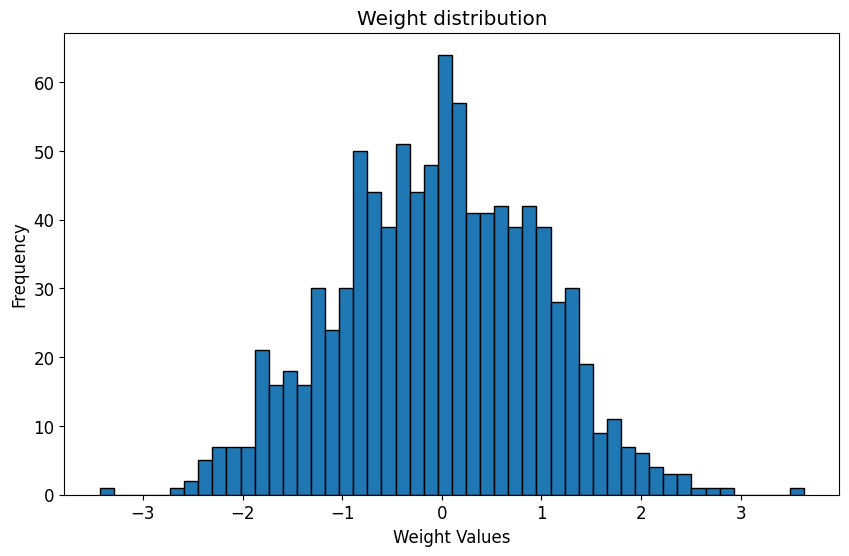

In [56]:
# this code was Generated with "claude.ai" - assitant AI

# comments written by a human ("group member")
# the idea is to start with embeddings for weights which are not all zeros
# and we can use .normal_({ mean }, { std }) 
# so not all random numbers start from zero, they start to be very small numbers 
# centered around 0, and we make sure random starting nums are close to zero by using a very low standard deviation

import  matplotlib.pyplot as plt
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(x.weight.detach().numpy().flatten(), bins=50, edgecolor='black')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.title('Weight distribution'); 


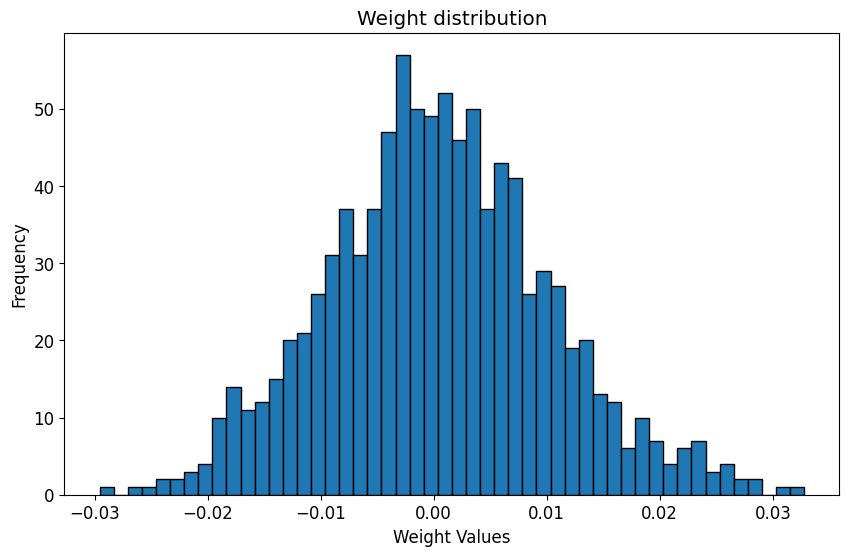

In [57]:

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(x1.detach().numpy().flatten(), bins=50, edgecolor='black')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.title('Weight distribution'); 

#### let's use the  `create_params function` to create learners

In [58]:
class DotProductEmbedding(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range
  
  def forward(self, x):
    # pytorch is very inspired by numpy as how they multiply the tensors in a very fast and efficient way
    # this is super cool and it comes from APL done by Kenneth E. Iverson in the 1960s
    
    users = self.user_factors[x[:,0]] # we are indexing - under the hood it does the dotproduct between the embedding matrix and the index being targeted
    movies = self.movie_factors[x[:,1]] # same as above - it returns the latent factors of the movies (all movie embeddings)
    res = (users * movies).sum(dim=1) # dotProduct, the thing that makes a NN a NN
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]] # add the bias as always
    return sigmoid_range(res, *self.y_range) # x = (1,2) , *x --> 1,2. *x will spread the content of the tuple, just like ...x in javascript
    
      
    
    

#### Let's train what we have created from scratch

In [59]:
model = DotProductEmbedding(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.871469,0.942351,00:11
1,0.679642,0.892697,00:10
2,0.529062,0.868474,00:10
3,0.435404,0.856752,00:11
4,0.434821,0.852385,00:10


In [60]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

how do we interpret the loss of 0.852 in the validation set ? 

In [61]:
# since the error is 0.852
# then the predictions will be 

true_rating_ex = 4
loss = 0.852
r_1 = true_rating_ex - loss
r_2= true_rating_ex + loss
print(f'the prediction for 4 stars will be {r_1} or {r_2}')


the prediction for 4 stars will be 3.148 or 4.852


is this rating resonable ? 

the scale of the ratings 1-5 means that a loss of 0.852 suggests that the model is fairly close to the correct rating. which is `resonable` in these kinds of problems

now we can move on to `predict` something, but how can this be done ? 

# Result 1

#### USING BIAS TO INTREPERT THE MODEL RESULTS

### This can be considered as a Recommendation for bad movies

this recommendation can be for people who want to see some bad movies to appreciate the good ones in the movie world

In [62]:
# low bias == bad movies 
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:10] # automatically in ascending order (bad to good movies)
[dls.classes['title'][i] for i in idxs]

['Grease 2 (1982)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Free Willy 2: The Adventure Home (1995)',
 'Showgirls (1995)',
 'Children of the Corn: The Gathering (1996)',
 'Spice World (1997)',
 'Cable Guy, The (1996)',
 "Amityville 1992: It's About Time (1992)",
 'All Dogs Go to Heaven 2 (1996)',
 'Robocop 3 (1993)']

as per chatgpt, without informing him any details about the bias, the generative AI could figure out the following: 

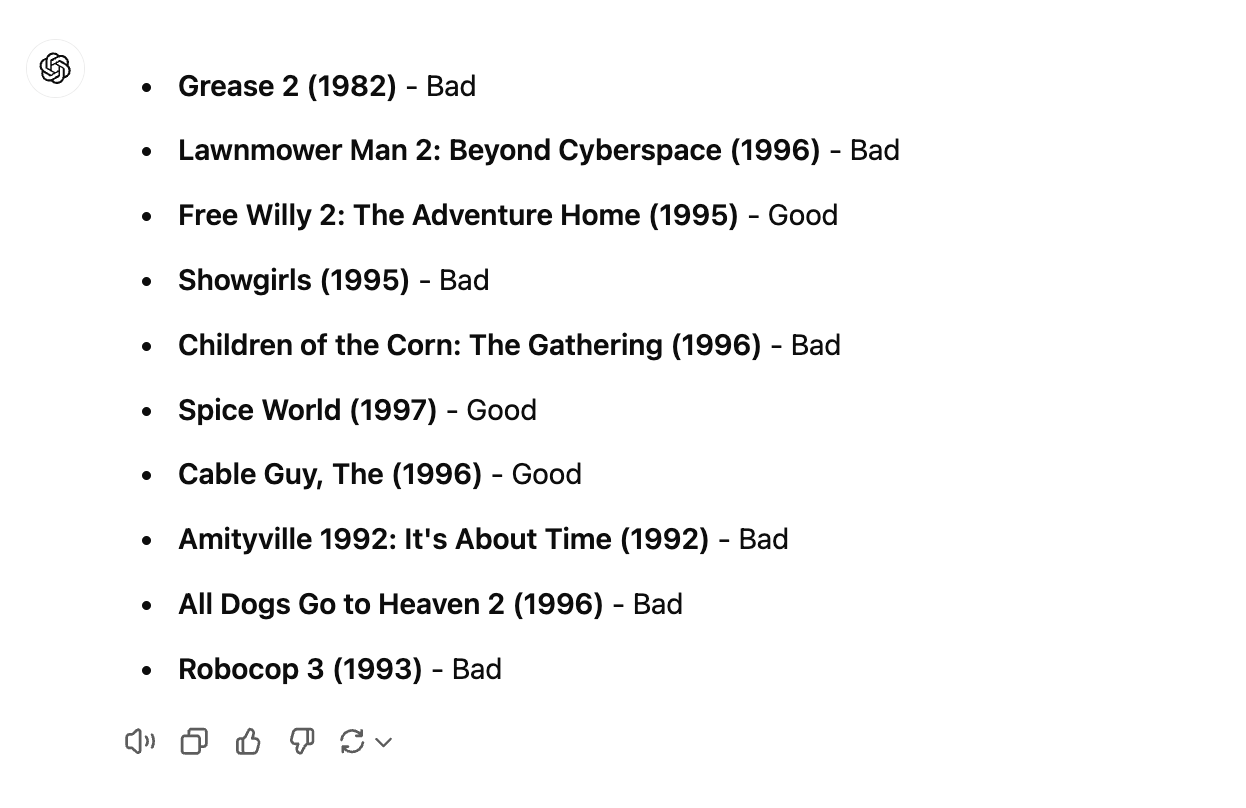


the chatbot, could identify that these movies are low quality.

### This can be considered as a Good Recommendation for anyone

this can solve the problem of a starting company, having no previous users. we can directly recommend watching these movies as they are considered movies who everyone can watch and enjoy due to different factors. 

In [63]:
# high bias movies, can be used to solve the new startup problem
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'Titanic (1997)',
 'Rear Window (1954)',
 "Schindler's List (1993)",
 'Star Wars (1977)',
 'Blade Runner (1982)',
 'Silence of the Lambs, The (1991)',
 'Raiders of the Lost Ark (1981)',
 'L.A. Confidential (1997)']

again `openAI ChatGPT` suggests the following: 


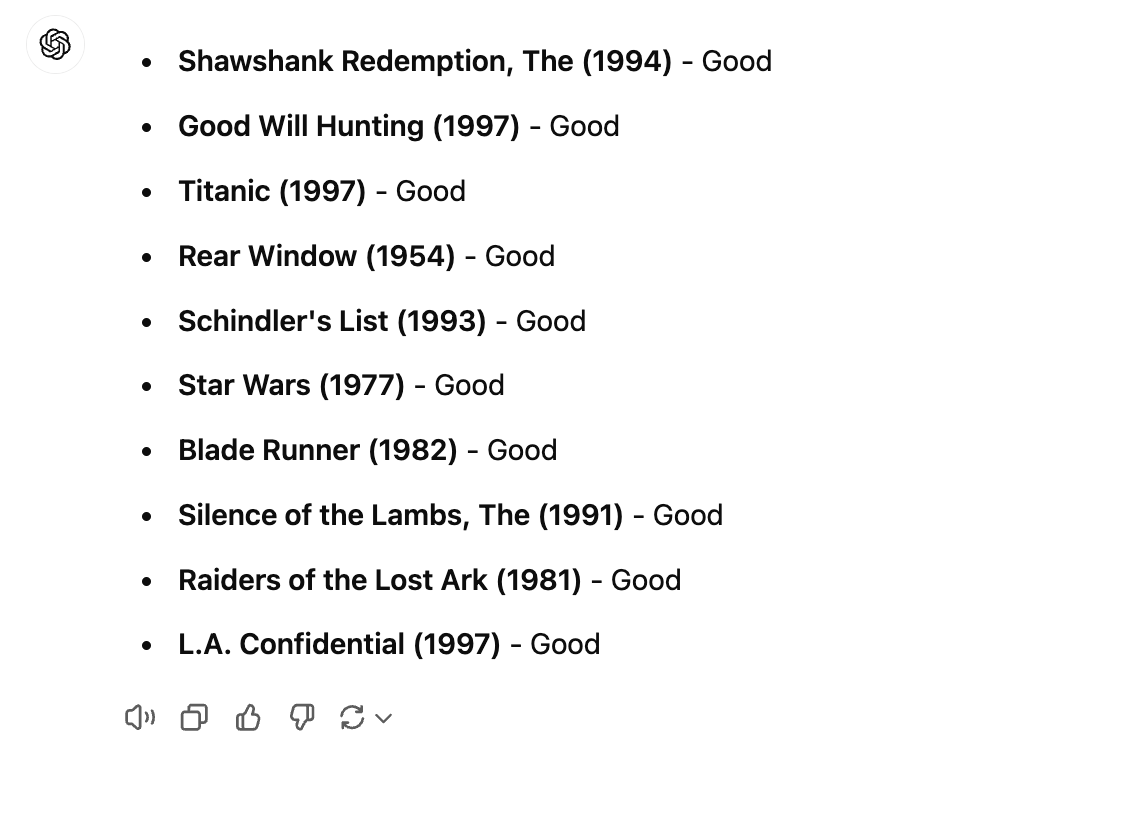

### Using fastai.collab


through using fastai, we can make a learner, just the like the code from scratch shown above. 

In [64]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

SuggestedLRs(slide=0.019054606556892395, valley=0.015848932787775993)

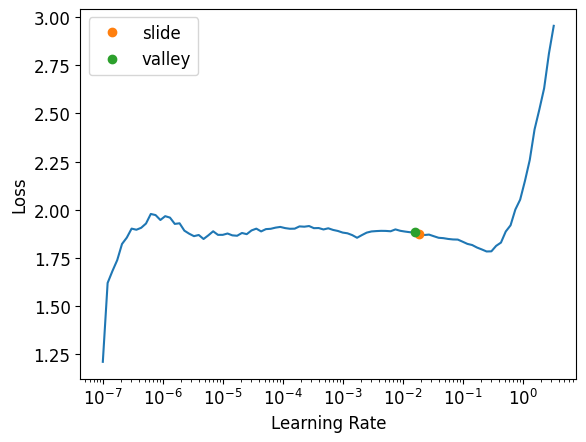

In [65]:
learn.lr_find(suggest_funcs=(slide, valley))

In [66]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.890238,0.940024,00:10
1,0.684089,0.889914,00:10
2,0.538726,0.870231,00:10
3,0.447707,0.855133,00:10
4,0.444007,0.852315,00:10


In [67]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [68]:
learn.opt_func # Optimizer used

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [69]:
movie_bias = learn.i_bias.weight.squeeze()
top_bias_idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in top_bias_idxs]

['Titanic (1997)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Rear Window (1954)',
 'Shawshank Redemption, The (1994)']

# Result 2

### Embedding Distance

if there were 2 movies which are nearly identical then there embedding matrices would be nearly identical. the same applies to people who likes these movies, they most probably would have also the embedding matrix as a users, so their embeddings would be nearly identical. 

the idea is that if we have 2 movies which are similar we can basically recommend those movies to these users, taking a movie the user watched, such as Titanic (1997), and recommeding similar movies to the titanic; using the CosineSimilarity to find the similar embedding matrix to the titanic movie, and recommending the most similar ones to the user. 

let's see this in action: 

In [70]:
# learn.model.i_weight.weight -- acessing the model movie embedding to check similar embeddings
# then finding the index of the embedding matrix of the titanic movie 
# then calculating the cosine similarity which check the most similar embeddings to the titanic movie embedding
# nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None]) -->  returns the most similar movies to the titanic
    # nn.CosineSimilarity(dim=1) -- calculate over the columns the cosineSimilarity
    # (movie_factors, movie_factors[idx][None]) --> movie_factors[idx][None] --> using [None] here just adds an extra dimension to the tensor, so shapes align with each other

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:10]
dls.classes['title'][idx]

(#9) ['Time to Kill, A (1996)','Good Will Hunting (1997)','Indiana Jones and the Last Crusade (1989)','Speed (1994)','Back to the Future (1985)','Selena (1997)','Primal Fear (1996)','That Old Feeling (1997)','Independence Day (ID4) (1996)']

the above list contains the movie recommendations based on the people who like the Titanic movie, so let's see how good our recommendations according to the ChatGPT since he is fed with lots and lots of movie knoweldge and we do not have the time or energy to watch all of these movies to decied weather it is a good movie or not: 


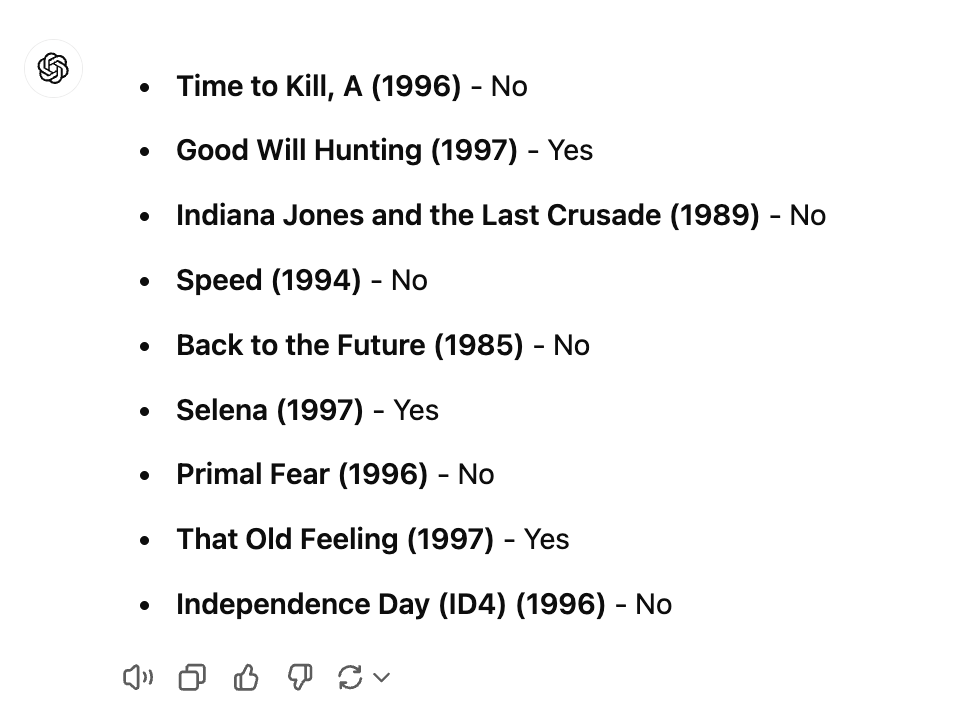

#### Deep Learning for Collaborative Filtering

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). fastai has a function get_emb_sz that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:

In [71]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [72]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [73]:
model = CollabNN(*embs)

SuggestedLRs(valley=0.007585775572806597, slide=0.00363078061491251)

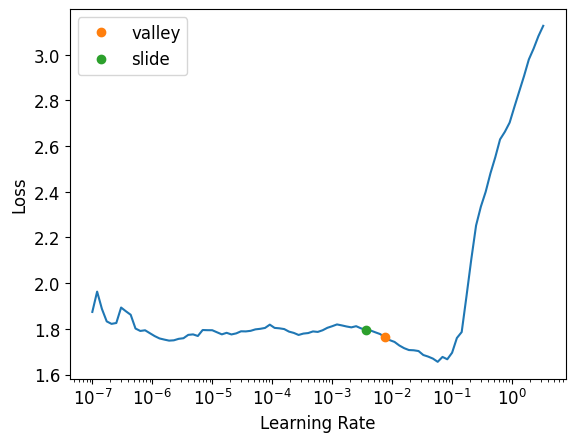

In [74]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.lr_find(suggest_funcs=(valley,slide))

In [75]:
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.928679,0.942479,00:12
1,0.878830,0.911713,00:11
2,0.830854,0.885205,00:12
3,0.772693,0.860514,00:11
4,0.771974,0.855831,00:12


In [76]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [77]:
learn.model

CollabNN(
  (user_factors): Embedding(944, 74)
  (item_factors): Embedding(1665, 102)
  (layers): Sequential(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

### include as a result ---

# using the fastai Way - deep learning model

the main purpose for this deep learning neural network is to predict the ratings for a given user based on the given movie title it will basically depend on the user latent factors (user embedding matrix) and movie embedding matrix. take the dot product of those and traa you can see the predicted rating. 

this predicted rating is then used to make recommendations for those users.

SuggestedLRs(valley=0.0030199517495930195, slide=0.015848932787775993)

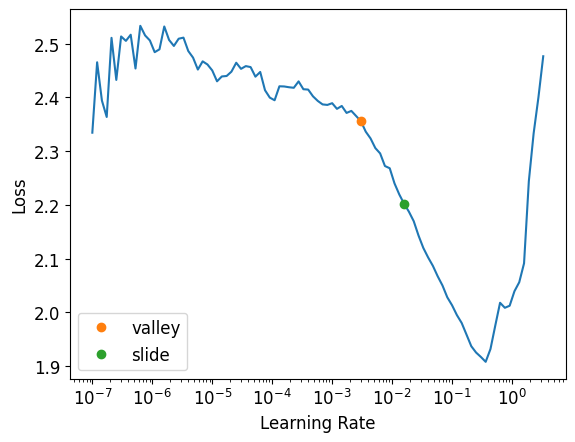

In [78]:
# use_nn=True will do the trick of activating the deep learning neural network

learn = collab_learner(
    dls,
    use_nn=True,
    y_range=(0, 5.5),
    layers=[100, 50, 25],
    opt_func=Adam,
    lr=5e-3,
)
learn.lr_find(suggest_funcs=(valley, slide))

In [79]:
learn.fit_one_cycle(10, 1e-1,wd=0.04)

epoch,train_loss,valid_loss,time
0,0.975757,1.026354,00:16
1,1.023297,1.010380,00:16
2,1.034022,1.069629,00:17
3,0.974919,0.974925,00:17
4,0.988878,0.971003,00:16
5,0.966264,1.057747,00:16
6,0.899590,0.936184,00:16
7,0.866846,0.903166,00:17
8,0.782117,0.859845,00:17
9,0.759939,0.850038,00:17


In [80]:
learn.model.layers[-2][0].bias

Parameter containing:
tensor([0.4433], device='cuda:0', requires_grad=True)

In [81]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=25, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=25, out_features=1, bias=True)
    )
    (4): fastai.laye

In [82]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [83]:
user_10 = ratings[(ratings['user'] == 10)][:10]
user_313 = ratings[(ratings['user'] == 313)].sample(10)
user_10_target  = ratings[(ratings['user'] == 10)]['rating'][:10]
user_313_target = user_313['rating'][:10]

In [84]:
user_313

,user,movie,rating,timestamp,title
23263,313,480,5,891013742,North by Northwest (1959)
15208,313,1210,4,891032028,Virtuosity (1995)
4157,313,969,4,891015387,Winnie the Pooh and the Blustery Day (1968)
18374,313,550,4,891028323,Die Hard: With a Vengeance (1995)
38474,313,495,2,891016280,Around the World in 80 Days (1956)
56511,313,546,4,891028426,Broken Arrow (1996)
25151,313,94,3,891030490,Home Alone (1990)
70115,313,651,3,891014552,Glory (1989)
1183,313,436,4,891029877,"American Werewolf in London, An (1981)"
44788,313,142,3,891030261,Bedknobs and Broomsticks (1971)


In [85]:
user_313_target

23263    5
15208    4
4157     4
18374    4
38474    2
56511    4
25151    3
70115    3
1183     4
44788    3
Name: rating, dtype: int64

In [86]:
dl_10 = learn.dls.test_dl(user_10)
dl_313 = learn.dls.test_dl(user_313)
pred_10 , _= learn.get_preds(dl=dl_10)
pred_313 , _= learn.get_preds(dl=dl_313)


In [87]:
import math
def cf_mse(pred, y): return round(((pred-y)**2).mean(), 6)

In [88]:
p_10 = to_np(pred_10.squeeze())
p_313 = to_np(pred_313.squeeze())


In [89]:
t_10 = torch.tensor(user_10_target.values,dtype=torch.float32)
t_313 = torch.tensor(user_313_target.values,dtype=torch.float32)

# Result 3

In [90]:
import torch.nn as nn
mse_loss = nn.MSELoss()
print(f'Pytorch MSEloss user 10: {mse_loss(pred_10.squeeze(),t_10)}')
print(f'Pytorch MSEloss user 313: {mse_loss(pred_313.squeeze(),t_313)}')

print(f'MSELoss from scratch: {cf_mse(p_10, user_10_target)}')
print(f'MSELoss from scratch: {cf_mse(p_313, user_313_target)}')


Pytorch MSEloss user 10: 0.3808080554008484
Pytorch MSEloss user 313: 0.9437059164047241
MSELoss from scratch: 0.380808
MSELoss from scratch: 0.943706


In [91]:
pred_313,user_313_target

(tensor([[4.3045],
         [2.5832],
         [3.6630],
         [3.2428],
         [3.8046],
         [2.7819],
         [2.9117],
         [4.1546],
         [3.5810],
         [2.9518]]),
 23263    5
 15208    4
 4157     4
 18374    4
 38474    2
 56511    4
 25151    3
 70115    3
 1183     4
 44788    3
 Name: rating, dtype: int64)

In [92]:
movie_factors = learn.model.embeds[1].weight


In [ ]:
### notice here

idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:10]
dls.classes['title'][idx]

(#9) ['Return of the Jedi (1983)','Manon of the Spring (Manon des sources) (1986)','Rear Window (1954)','My Man Godfrey (1936)','Much Ado About Nothing (1993)','Forbidden Planet (1956)','Contact (1997)','Ben-Hur (1959)','Sabrina (1954)']

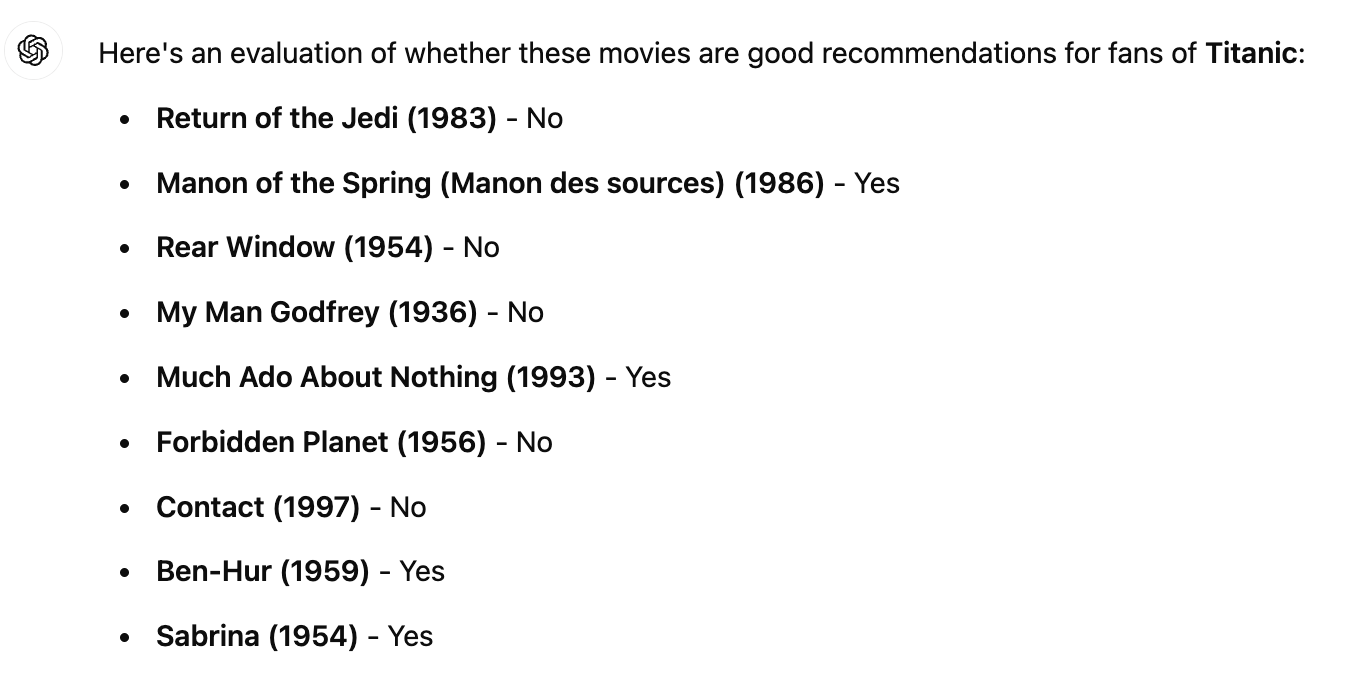

our work compared to a kaggle notebook that is made 6 years ago:
https://www.kaggle.com/code/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization#5.-4)-Fitting-on-Training-set-&-Validating-on-Validation-Set.







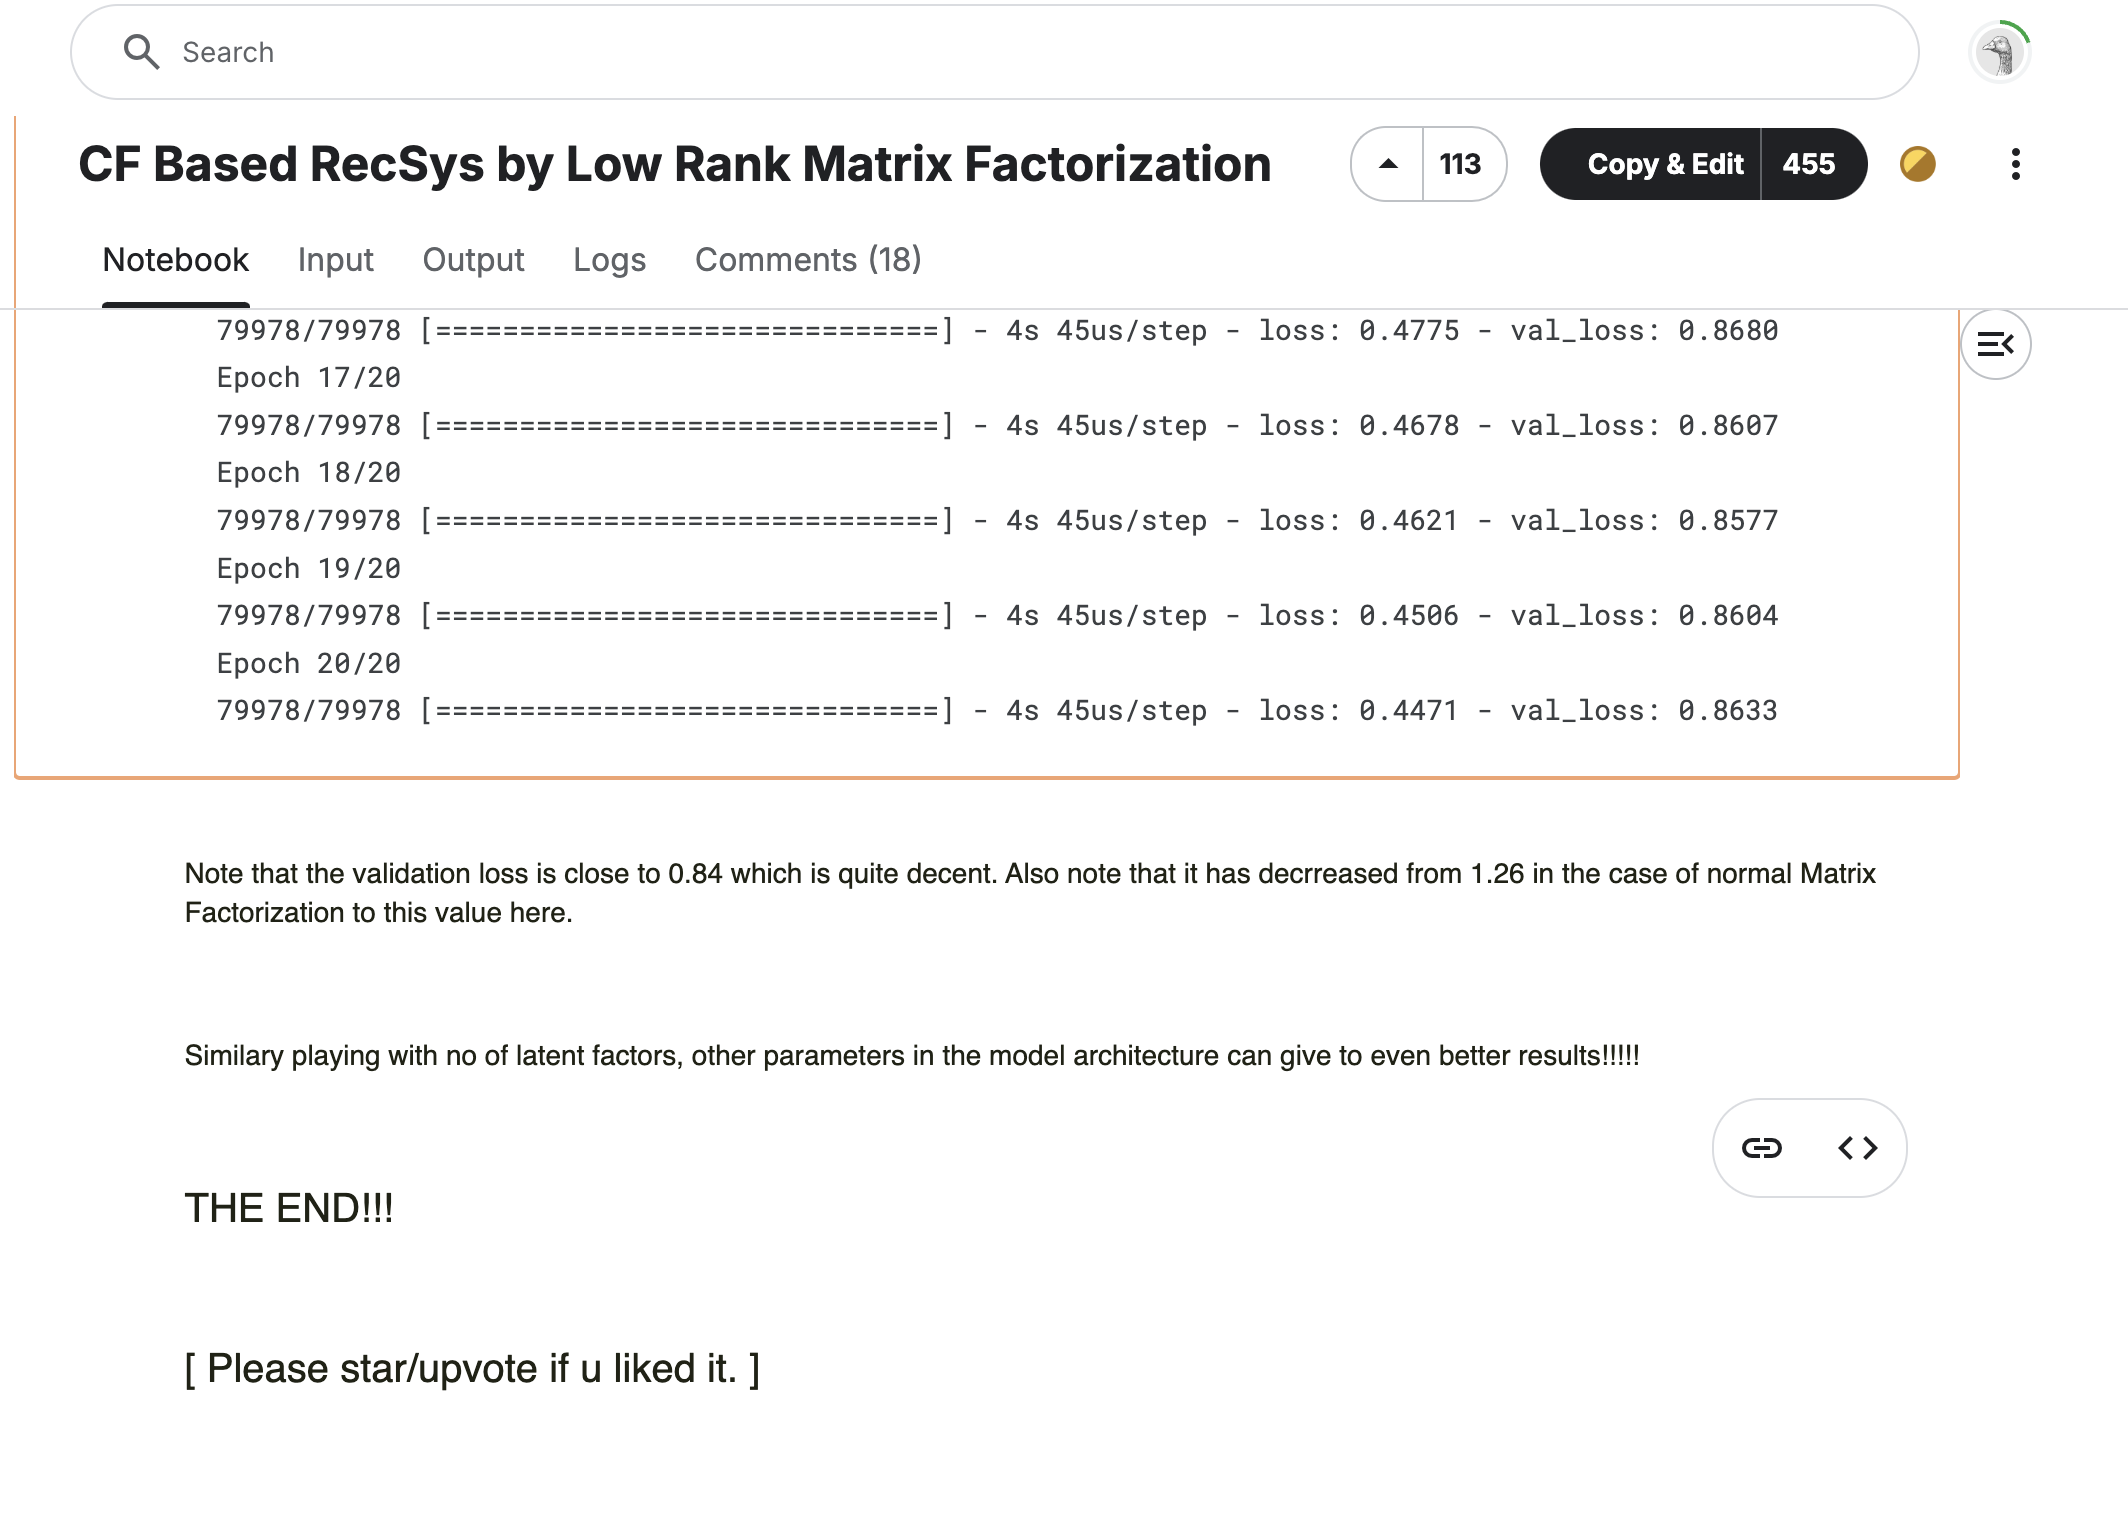

## FUTURE WORK

- do the same work over the 25 million datapoints in the actual movie lens dataset
- try to improve the given models to a score of 0.5 or lower
- do a computer vision model that will take a picture and return a prediction 
- learn the main core concepts of deep learnig, such as: 
    - Neural network basics
    - computer vision basics
    - multi-category predictions
    - collaborative filtering basics to drill down the ideas of the the recommendation systems
    - tabular data basics: using random forests, decision trees, xgboost, and deep learning
    - nlp(natural language processing)
    - and more .... 
- learn more about transfer learning

This is a very big field, & it's changing rapidly { what you use now may be outdated after 1 or 2 years }. The main goal is to study the concepts, because they are the same since `1950` { what you learn will be with you }.

# Resources

- openAI chatGPT
- fastai book chapter 08: https://github.com/fastai/fastbook/blob/master/08_collab.ipynb
- fastai docs: https://docs.fast.ai/

learning resources: 
- https://course.fast.ai/
- https://github.com/fastai/fastbook/blob/master/08_collab.ipynb


other learning resources for `future work`: 

- https://github.com/fastai/numerical-linear-algebra ( This course was taught in university of san fransisco , masters of science in Analytics program - "for graduate students studying to become data scientists" )